In [1]:
from datetime import datetime
from constants.CONSTANTS import *
from aia_image_api import imageparam_getter as ipg
import numpy as np
from datetime import timedelta 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


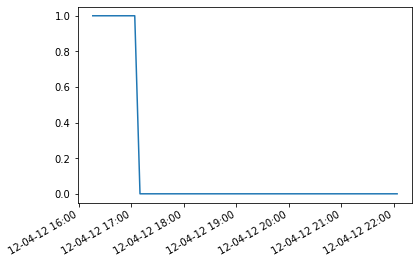

In [2]:
def QualityChecker_single(dt_start,days2check,aia_wave,image_size,param_id,DatesDF):
    dt=dt_start=datetime.strptime(dt_start, '%Y-%m-%dT%H:%M:%S')
    dt_stop = dt_start+timedelta(days=days2check) 
    thereshold=0
    while dt<dt_stop:
        if (DatesDF['date']==dt).any():
            dt=dt+timedelta(minutes=6)
            continue
        xml = ipg.get_aia_imageparam_xml(dt, aia_wave)
        res = ipg.convert_param_xml_to_ndarray(xml)
        entropyValues=res[:,:,(int(param_id)-1):int(param_id)].reshape(64, 64)
        if dt==dt_start:
            lastcorrectmat=entropyValues
            dt=dt+timedelta(minutes=6)
            continue
        diffmat_from_last_correct=np.absolute(np.subtract(lastcorrectmat, entropyValues))
        rot_diffmat_from_last_correct=np.absolute(np.subtract(lastcorrectmat, np.rot90(entropyValues)))
        diffsum=np.sum(diffmat_from_last_correct)
        rot_diffsum=np.sum(rot_diffmat_from_last_correct)
        if rot_diffsum<diffsum:
            DatesDF.loc[len(DatesDF)]=[dt,diffsum,0,aia_wave,image_size,param_id]
            lastcorrectmat=np.rot90(entropyValues)
        else:
            DatesDF.loc[len(DatesDF)]=[dt,diffsum,1,aia_wave,image_size,param_id]
            lastcorrectmat=entropyValues

        dt=dt+timedelta(minutes=6)  
    return DatesDF

def QualityChecker(dt_start,days2check,aia_wave_array,image_size_array,param_id_array):
    '''
    dt_start should be string in format YYYY-MM-DDTHH:MM:SS example: 2012-04-12T16:10:00
    days2check represents how many days from start date you want to check quality example: 0.2, 1, 5, 30
    '''
    DatesDF=pd.DataFrame(columns=['date','diff','good','aia_wave','image_size','param_id'])
    for aia_wave in aia_wave_array:
        for image_size in image_size_array:
            for param_id in param_id_array:
                DatesDF=QualityChecker_single(dt_start,days2check,aia_wave,image_size,param_id,DatesDF)
    DatesDFplot=DatesDF[['date','good']].sort_values(by=['date']).reset_index(drop=True)
    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    plt.plot(DatesDFplot['date'],DatesDFplot['good'])
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    plt.show()
    return DatesDF

#12th april 2012 12pm -- 3 days
DatesDF=QualityChecker('2012-04-12T16:10:00',0.25,[AIA_WAVE.AIA_171],[IMAGE_SIZE.P2000],['1'])
# DatesDF=QualityChecker('2012-04-12T16:10:00',0.2,[AIA_WAVE.AIA_171],[IMAGE_SIZE.P2000],['1','2'])

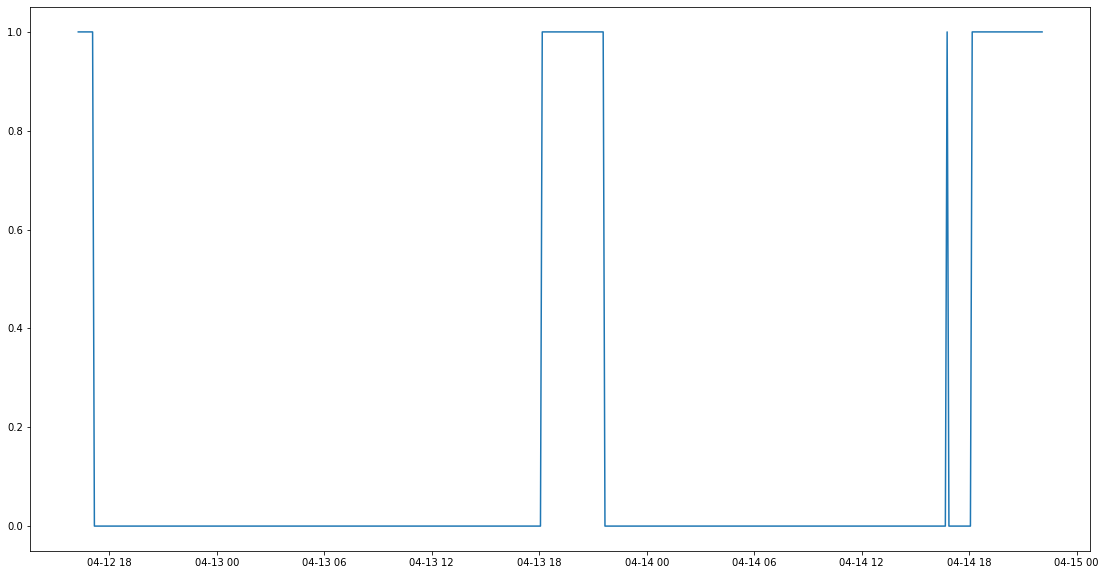

In [123]:
DatesDFplot=DatesDF[['date','good']].sort_values(by=['date']).reset_index(drop=True)



plt.figure(figsize=(19, 10))
#fig.figsize=(19, 10)
fig.autofmt_xdate()
plt.plot(DatesDFplot['date'],DatesDFplot['good'])
xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.show()

# fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')
# plt.suptitle('Count versus Magnitude of Earthquake', x=0.5, y=1.05, ha='center', fontsize='xx-large')
